In [57]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset 
from transformers import AdamW, BertModel, BertTokenizer, get_linear_schedule_with_warmup

In [58]:
BATCH_SIZE = 1
CATEGORY = "polarity"
EPOCHS = 5
MAX_LENGTH = 125
MODEL_TAG = "bert-base-uncased"

### Exploratory data analysis

In [59]:
labels_path = "mined_gold_standard/labels"
composite_dataframe = pd.DataFrame(columns = ["text", CATEGORY])

for conversation in os.listdir(labels_path):
    if CATEGORY in conversation:
        local_dataframe = pd.read_csv(os.path.join(labels_path, conversation), delimiter = "\t")
        composite_dataframe = pd.concat([composite_dataframe, local_dataframe], ignore_index = True)

composite_dataframe   

,text,polarity
0,"Hi, Iam 34years old & my sonography says Solid...",NEUTRAL
1,what does it means ?,NEUTRAL
2,doctor advised to go for FNAC for further eval...,NEGATIVE
3,is anything serious please tell me i'am very m...,NEGATIVE
4,thanks.,NOT_LABELED
...,...,...
3630,Take vitamins.,NEUTRAL
3631,It was only a matter of time and not your medi...,NEUTRAL
3632,Has anyone experienced hair loss with using 6m...,NEUTRAL
3633,I've been on it for 2 months and noticed hair ...,NEGATIVE


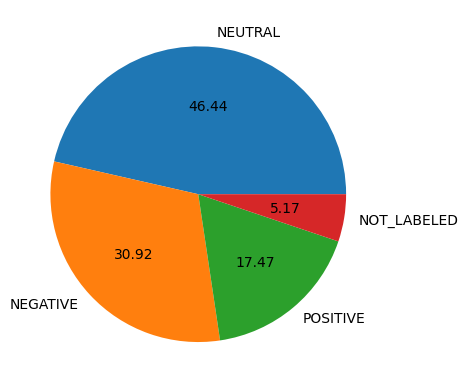

In [60]:
counts = composite_dataframe[CATEGORY].value_counts()

fig, ax = plt.subplots()
_ = ax.pie(list(counts.values), labels = 
           list(counts.index), autopct = "%.2f")

In [61]:
composite_dataframe = composite_dataframe[composite_dataframe[CATEGORY] != "NOT_LABELED"].reset_index(drop = True)

composite_dataframe[CATEGORY] = composite_dataframe[CATEGORY].map({"NEGATIVE" : 0,
                                                                   "NEUTRAL" : 1,
                                                                   "POSITIVE" : 2})

### BERT (fine-tuning for sentiment analysis)

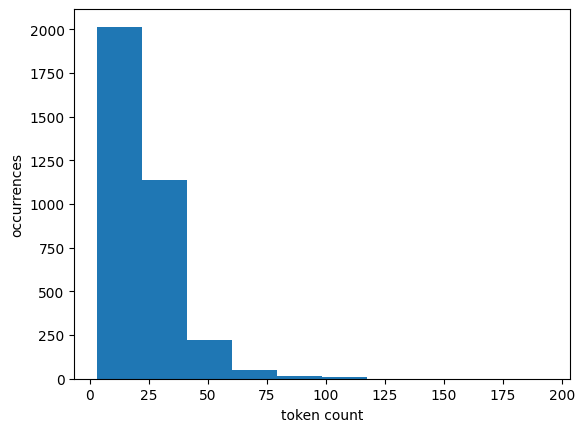

In [62]:
tokenizer = BertTokenizer.from_pretrained(MODEL_TAG)
composite_lengths = composite_dataframe["text"].apply(lambda s : len(tokenizer.encode(s, max_length = 512,
                                                                                      truncation = True)))

fig, ax = plt.subplots()
_ = ax.hist(list(composite_lengths.values))
_ = ax.set_xlabel("token count")
_ = ax.set_ylabel("occurrences")

In [63]:
class GoldStandard(Dataset):
    def __init__(self, sentences, targets, tokenizer, max_length):
        self.sentences = sentences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            sentence, 
            add_special_tokens = True, 
            max_length = self.max_length,
            return_token_type_ids = False,
            padding = "max_length",
            return_attention_mask = True,
            return_tensors = "pt"
        )
        
        return {
            "sentence_text" : sentence,
            "input_ids" : encoding["input_ids"].flatten(),
            "attention_mask" : encoding["attention_mask"].flatten(),
            "targets" : torch.tensor(target, dtype = torch.long)
        }

In [64]:
class SentimentAnalyzer(nn.Module):
    def __init__(self, num_classes):
        super(SentimentAnalyzer, self).__init__()
        self.model = BertModel.from_pretrained(MODEL_TAG)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.model.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict = False
        )
        
        output = self.drop(pooled_output)
        return self.out(output)

In [65]:
def data_loader(dataset, tokenizer, max_length, batch_size):
    wrapper = GoldStandard(
        sentences = dataset["text"].to_numpy(),
        targets = dataset[CATEGORY].to_numpy(),
        tokenizer = tokenizer,
        max_length = max_length
    )
    
    return DataLoader(
        wrapper,
        batch_size = batch_size,
        num_workers = 0
    )

In [66]:
def train_epoch(model, data_loader, loss_function,
                optimizer, device, scheduler, num_samples):
    model = model.train()
    
    correct_predictions = 0
    losses = []
    
    for data in data_loader:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["targets"].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _, predictions = torch.max(outputs, dim = 1)
        correct_predictions += torch.sum(predictions == targets)

        loss = loss_function(outputs, targets)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / num_samples, np.mean(losses)

def evaluate_model(model, data_loader, loss_function, device, num_samples):
    model = model.eval()
    
    correct_predictions = 0
    losses = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )
            
            _, predictions = torch.max(outputs, dim = 1)
            correct_predictions += torch.sum(predictions == targets)
    
            loss = loss_function(outputs, targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / num_samples, np.mean(losses)

In [67]:
train, test = train_test_split(composite_dataframe, test_size = 0.25, random_state = 0)
validation, test = train_test_split(test, test_size = 0.8, random_state = 0)

(train.shape, validation.shape, test.shape)

((2585, 2), (172, 2), (690, 2))

In [68]:
train_data_loader = data_loader(train, tokenizer, MAX_LENGTH, BATCH_SIZE)
validation_data_loader = data_loader(validation, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = data_loader(test, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")

model = SentimentAnalyzer(len(pd.unique(composite_dataframe[CATEGORY]))).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = EPOCHS * len(train_data_loader)
)

loss_function = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
history = {"training_accuracy" : [],
           "training_loss" : [],
           "validation_accuracy" : [],
           "validation_loss" : []}

highest_accuracy = 0.0

for epoch in range(EPOCHS):
    print("Epoch: {} / {}".format(epoch + 1, EPOCHS))
    
    training_accuracy, training_loss = train_epoch(
        model,
        train_data_loader,
        loss_function,
        optimizer,
        device,
        scheduler,
        train.shape[0]
    )
    
    print("Training loss: {}".format(training_loss), end = " | ")
    print("Training accuracy: {}".format(training_accuracy))
    
    validation_accuracy, validation_loss = evaluate_model(
        model,
        validation_data_loader,
        loss_function,
        device,
        validation.shape[0]
    )
    
    print("Validation loss: {}".format(validation_loss), end = " | ")
    print("Validation accuracy: {}".format(validation_accuracy))
    
    history["training_accuracy"].append(training_accuracy)
    history["training_loss"].append(training_loss)
    history["validation_accuracy"].append(validation_accuracy)
    history["validation_loss"].append(validation_loss)
    
    if validation_accuracy > highest_accuracy:
        torch.save(model.state_dict(), "eDiseases.pt")
        highest_accuracy = validation_accuracy

Epoch: 1 / 5


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.